In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

from going_modular import data_setup, engine

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# TODO: Functionize this so it can be used in other notebooks 
import os
if not os.path.exists("data/10_whole_foods"):
  !wget https://storage.googleapis.com/food-vision-image-playground/10_whole_foods.zip
  !unzip -q 10_whole_foods.zip -d data
else:
  print("data/10_whole_foods dir exists, skipping download")

data/10_whole_foods dir exists, skipping download


In [4]:
# Setup Dirs
train_dir = "data/10_whole_foods/train"
test_dir = "data/10_whole_foods/test"

from torchvision.datasets import ImageFolder

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
  test_dir=test_dir,
  transform=simple_transform,
  batch_size=32
)

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7f5d201ee820>,
 ['apple',
  'banana',
  'beef',
  'blueberries',
  'carrots',
  'chicken_wings',
  'egg',
  'honey',
  'mushrooms',
  'strawberries'])

In [5]:
model = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Print a summary
# summary(model, input_shape=(1, 3, 224, 224))

In [6]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [7]:
# Update the classifier
model.classifier = torch.nn.Linear(1280, 10).to(device)

# Freeze all base layers (the feature extractor in EfficientNet)
for param in model.features.parameters():
  param.requires_grad = False

# Print a summary
# model

## Train model

In [8]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train model
results = engine.train(model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=5)

 20%|██████████▊                                           | 1/5 [00:02<00:09,  2.46s/it]

Epoch: 1 | train_loss: 1.8854 | train_acc: 0.5072 | test_loss: 1.3689 | test_acc: 0.8125


 40%|█████████████████████▌                                | 2/5 [00:04<00:05,  1.98s/it]

Epoch: 2 | train_loss: 1.1764 | train_acc: 0.8276 | test_loss: 1.0145 | test_acc: 0.8229


 60%|████████████████████████████████▍                     | 3/5 [00:05<00:03,  1.84s/it]

Epoch: 3 | train_loss: 0.8214 | train_acc: 0.8659 | test_loss: 0.7632 | test_acc: 0.8698


 80%|███████████████████████████████████████████▏          | 4/5 [00:07<00:01,  1.77s/it]

Epoch: 4 | train_loss: 0.6256 | train_acc: 0.9062 | test_loss: 0.6190 | test_acc: 0.8646


100%|██████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.82s/it]

Epoch: 5 | train_loss: 0.5076 | train_acc: 0.9196 | test_loss: 0.6438 | test_acc: 0.8333


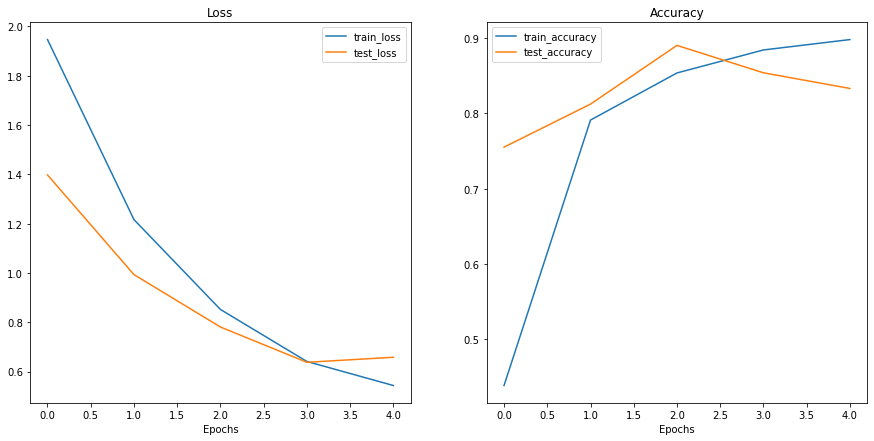

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## TK - Extensions + Exercises
* Try a different model from PyTorch pretrained models
* Train for longer, what happens?
* Could you add in some data augmentation? What happens then?

## TK - Extra-curriculum
* Check out the PyTorch multi-weights API (still in beta at time of writing, March 2022) - https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/